**Project Computer Vision Part 2**

**KUMUD KUMAR**

**PART A**

**DOMAIN:** Entertainment

**CONTEXT:** Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the 

**DATA DESCRIPTION:** The dataset comprises of images and its mask for corresponding human face

**PROJECT OBJECTIVE:** To build a face detection system

**1. IMPORT AND UNDERSTAND THE DATA** 

In [18]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.8.2'

In [19]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [20]:
# IMPORTING USEFUL LIBRARIES
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray
from tensorflow.keras.applications.mobilenet import preprocess_input

1.A IMPORT AND READ IMAGES

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import os
print(os.listdir("../content"))

['.config', 'drive', 'sample_data']


In [23]:
image_data=np.load('/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/images.npy', allow_pickle = True)

In [24]:
# shape of data
image_data.shape

(409, 2)

1.B Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [25]:
# assigning pixe size to height, width of image 

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

masks = np.zeros((int(image_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(image_data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(image_data.shape[0]):
  img = image_data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)

  # assigning all pixels in the first 3 channels only to the image, discarding the alpha channel
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")

    # converting the grayscale image to color so number of channels are standardized to 3
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))

  # Loop through the face co-ordinates and create mask out of it.
  for i in image_data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


1.C Splitting data into train and test [400:9]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=8/400)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(" ")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(400, 224, 224, 3)' and the shape of y_train is '(400, 224, 224)'
 
Shape of X_test is '(9, 224, 224, 3)' and the shape of y_test is '(9, 224, 224)'


1.D Select random image from the train data and display original image and masked image

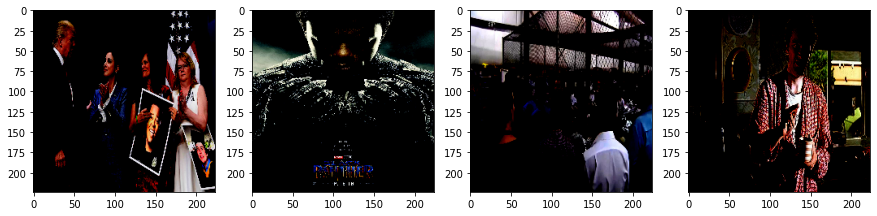

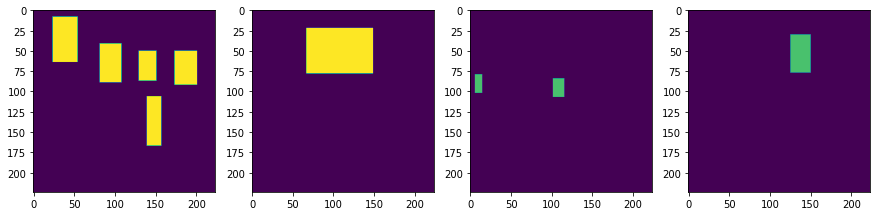

In [27]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[15])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[45])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[15])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[45])
imgplot.set_clim(0.0, 1.4)

**2. MODEL BUILDING**

2.A Face mask detection model

In [28]:
IMAGE_SIZE = 224
EPOCHS = 20
BATCH = 8
LR = 1e-4

In [29]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [30]:
# model summary

model = model()
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                                           

2.B Designing our own Dice Coefficient and Loss function

In [31]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

2.C Train and tune the model as required

In [32]:
# compiling the model 

metrics = [dice_coef, Recall(), Precision()]
optm = tf.keras.optimizers.Nadam(LR)

model.compile(loss=dice_loss, optimizer=optm, metrics=metrics)

In [33]:
# callbacks 

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [34]:
# fitting the model 

train_steps = len(X_train)//BATCH
valid_steps = len(X_test)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_test) % BATCH != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/20
50/50 [==============================] - 179s 3s/step - loss: 0.7193 - dice_coef: 0.2807 - recall_1: 0.8806 - precision_1: 0.1941 - val_loss: 0.7000 - val_dice_coef: 0.3076 - val_recall_1: 1.0000 - val_precision_1: 0.1643 - lr: 1.0000e-04
Epoch 2/20
50/50 [==============================] - 162s 3s/step - loss: 0.6309 - dice_coef: 0.3691 - recall_1: 0.9230 - precision_1: 0.3808 - val_loss: 0.6866 - val_dice_coef: 0.3209 - val_recall_1: 0.9996 - val_precision_1: 0.1739 - lr: 1.0000e-04
Epoch 3/20
50/50 [==============================] - 165s 3s/step - loss: 0.6054 - dice_coef: 0.3946 - recall_1: 0.9114 - precision_1: 0.4595 - val_loss: 0.6340 - val_dice_coef: 0.3731 - val_recall_1: 0.9813 - val_precision_1: 0.2604 - lr: 1.0000e-04
Epoch 4/20
50/50 [==============================] - 164s 3s/step - loss: 0.5915 - dice_coef: 0.4085 - recall_1: 0.9167 - precision_1: 0.4953 - val_loss: 0.5915 - val_dice_coef: 0.4155 - val_recall_1: 0.9536 - val_precision_1: 0.3812 - lr: 1.0000e-04


2.D  Evaluating and sharing insights on performance of the model.

In [35]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

2/2 [==============================] - 1s 346ms/step - loss: 0.5156 - dice_coef: 0.4917 - recall_1: 0.6660 - precision_1: 0.6803


[0.5156427621841431, 0.4917004406452179, 0.6659610867500305, 0.680324912071228]

The model has precision and recall of 68.03% and 66.60% respectively. The loss is 51.56% and dice coefficient is 49.17%


**3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.**

In [36]:
import cv2

image_index = X_test[3]

y_pred = model.predict(np.array([image_index]))
y_pred

array([[[[0.24243101],
         [0.15744242],
         [0.15189064],
         ...,
         [0.15878001],
         [0.14523509],
         [0.24173397]],

        [[0.20435676],
         [0.12722003],
         [0.13074082],
         ...,
         [0.13591495],
         [0.10901073],
         [0.1667751 ]],

        [[0.18087831],
         [0.11491746],
         [0.13664722],
         ...,
         [0.18888488],
         [0.13713184],
         [0.17973119]],

        ...,

        [[0.21609822],
         [0.1731734 ],
         [0.1918805 ],
         ...,
         [0.22296497],
         [0.19076279],
         [0.23183632]],

        [[0.21402821],
         [0.16793546],
         [0.1833778 ],
         ...,
         [0.20105022],
         [0.17527196],
         [0.2305966 ]],

        [[0.29438135],
         [0.23782635],
         [0.23300284],
         ...,
         [0.2239599 ],
         [0.22783467],
         [0.32936603]]]], dtype=float32)

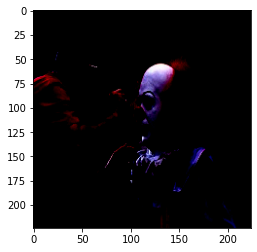

In [37]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))
plt.imshow(image_index)

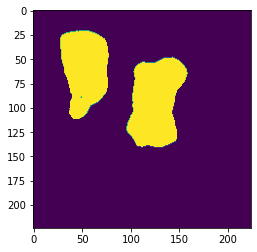

In [38]:
plt.imshow(pred_mask)

**Part B**
**DOMAIN:** Entertainment

**CONTEXT:** Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene. The data labelling is already done. Since there higher time complexity is involved in the

**DATA DESCRIPTION:** The dataset comprises of face images.

**PROJECT OBJECTIVE:** To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

**1. Read/import images from folder ‘training_images’**


In [42]:
!unzip "/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images-20211126T092819Z-001.zip" -d "/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images"

Archive:  /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images-20211126T092819Z-001.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_00947.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_01052.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_01042.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_00964.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_01053.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_00971.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real

2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images

In [40]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
              metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

3. From the same loop above, extract metadata of the faces and write into a DataFrame

In [44]:
metadata = load_metadata('/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/')

In [45]:
metadata 

array([/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_00947.jpg,
       /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_01052.jpg,
       /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_01042.jpg,
       ...,
       /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_00247.jpg,
       /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_00134.jpg,
       /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/training_images/training_images/real_00166.jpg],
      dtype=object)

In [46]:
datafrme = pd.DataFrame(metadata)

4. Save the output Dataframe in .csv format

In [47]:
datafrme.to_csv(r'/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/csvdata.csv', index=False)

**PART C:**

DOMAIN: Face Recognition
• CONTEXT: Company X intends to build a face identification model to recognise human faces.
• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library.

1. UNZIP THE FOLDER

In [48]:
!unzip "/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/PINS.zip" -d "/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/PINS"


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/PINS/PINS/pins_Natalie Portman /Natalie Portman 43.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/PINS/__MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 43.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/PINS/PINS/pins_Natalie Portman /Natalie Portman 57.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/PINS/__MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 57.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/PINS/PINS/pins_Natalie Portman /Natalie Portman 9.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/PINS/__MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 9.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/PINS/PINS/pins_Natalie 

In [49]:
import os
entries = os.listdir('/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/PINS/PINS/')
for entry in entries:
  print(entry)

pins_mark zuckerberg
pins_amber heard face
pins_Martin Starr
pins_barbara palvin face
pins_Jason Momoa
pins_Pedro Alonso
pins_jason isaacs
pins_Chris Pratt
pins_Jim Parsons
pins_Emilia Clarke
pins_Sophie Turner
pins_Amaury Nolasco
pins_Willa Holland
pins_Paul Rudd
pins_Bryan Cranston
pins_lindsey morgan face
pins_Rami Melek
pins_Jesse Eisenberg
pins_Scarlett Johansson
pins_kristen stewart face
pins_dua lipa face
pins_Robin Taylor
pins_Peter Dinklage
pins_Morena Baccarin
pins_brie larson
pins_Jeremy Renner
pins_Morgan Freeman
pins_Tom Cavanagh
pins_Emma Stone
pins_taylor swift
pins_Alvaro Morte
pins_Aaron Paul
pins_Brit Marling
pins_Chance Perdomo
pins_tom holland face
pins_rihanna
pins_Anna Gunn
pins_alexandra daddario
pins_eliza taylor
pins_Dave Franco
pins_Cameron Monaghan
pins_Kumail Nanjiani
pins_bellamy blake face
pins_bill gates
pins_drake
pins_elon musk
pins_gal gadot face
pins_Sundar Pichai
pins_Robert Knepper
pins_miguel herran
pins_Melissa benoit
pins_millie bobby brown
pins_

In [50]:
# Write function to create metadata of the image

import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 

3. Write a loop to iterate through each and every image and create metadata for all the images

In [51]:
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
              metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [52]:
metadata = load_metadata('/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/PINS/PINS/')
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [53]:
load_image(metadata[0].image_path())

array([[[67, 56, 50],
        [62, 51, 45],
        [56, 45, 39],
        ...,
        [22, 19, 12],
        [22, 19, 12],
        [23, 18, 12]],

       [[65, 54, 48],
        [64, 53, 47],
        [56, 45, 39],
        ...,
        [22, 19, 12],
        [22, 19, 12],
        [23, 18, 12]],

       [[61, 50, 46],
        [59, 48, 44],
        [47, 36, 30],
        ...,
        [23, 18, 12],
        [23, 18, 12],
        [23, 18, 12]],

       ...,

       [[60, 40, 41],
        [60, 40, 41],
        [56, 36, 37],
        ...,
        [30, 21, 16],
        [31, 22, 17],
        [31, 22, 17]],

       [[60, 40, 41],
        [60, 40, 41],
        [57, 37, 38],
        ...,
        [30, 21, 16],
        [31, 22, 17],
        [31, 22, 17]],

       [[61, 41, 42],
        [60, 40, 41],
        [57, 37, 38],
        ...,
        [30, 21, 16],
        [31, 22, 17],
        [31, 22, 17]]], dtype=uint8)

4. Generate Embeddings vectors on the each face in the dataset

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [55]:
from tensorflow.keras.models import model_from_json
model = vgg_face()
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/vgg_face_weights.h5')

In [56]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [57]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [58]:
embeddings = np.zeros((metadata.shape[0], 2622))
k = 0
for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        if k % 500 == 0:
            print(k)
        # scale RGB values to interval [0,1]
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
        k += 1
    except Exception as e:
        print(str(e))
        print(i,m)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500


5. Build distance metrics for identifying the distance between two similar and dissimilar images


In [59]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

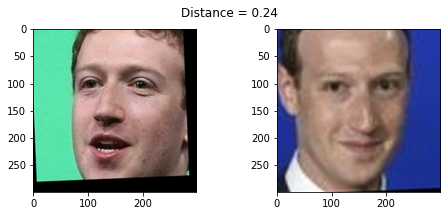

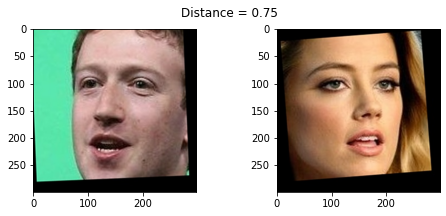

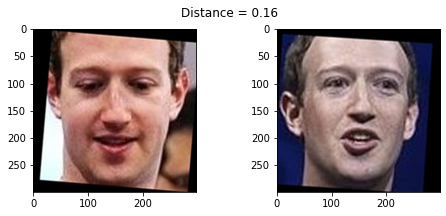

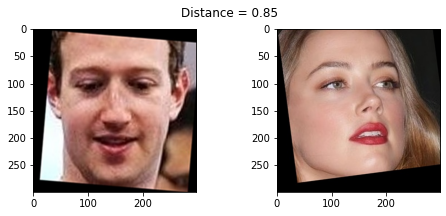

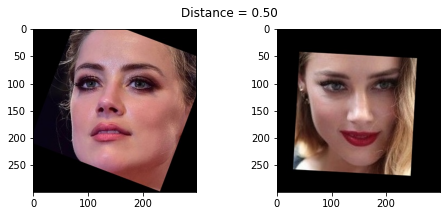

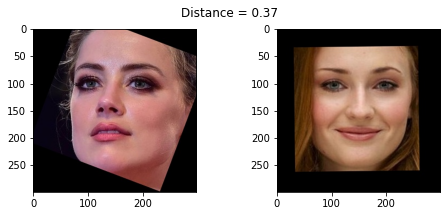

In [60]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(4, 5)
show_pair(4, 170)

show_pair(25,31)
show_pair(25,100)

show_pair(188,190)
show_pair(188,1200)

**6. PCA for dimensionality reduction** 

In [61]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [63]:

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [64]:

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

**7. Build an SVM classifier in order to map each image to its right person** 

In [65]:
from sklearn.svm import SVC
from sklearn import svm, metrics

clf = SVC(kernel='rbf', class_weight=None , C=10000000, gamma='auto')
clf.fit(X_train, y_train)
svm_score = clf.score(X_test, y_test)
svm_score


0.9590643274853801

In [66]:
y_pred = clf.predict(X_test)
svm_accuracy = metrics.accuracy_score(y_test, y_pred)
svm_accuracy

0.9590643274853801

**8. Import and display the the test images** 

In [67]:
test_path1 = '/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/Benedict Cumberbatch9.jpg'
test_path2 = '/content/drive/MyDrive/Colab Notebooks/CV Project/CV2 Project/CV2/Dwayne Johnson4.jpg'

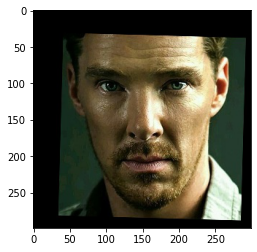

In [68]:
image_1 = plt.imread(test_path1)
plt.imshow(image_1)

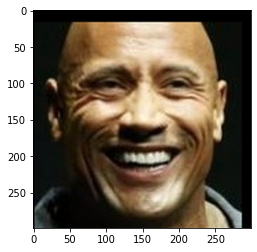

In [69]:
image_2 = plt.imread(test_path2)
plt.imshow(image_2)

**9. Use the trained SVM model to predict the face on both test images** 

In [70]:
img_pred_resize = cv2.resize(image_1,(224,224), interpolation = cv2.INTER_CUBIC)
img_predict_ = np.expand_dims(img_pred_resize, axis=0)

In [71]:
pred_svm_1 = clf.predict(image_1)
svm_accuracy_1 = metrics.accuracy_score(image_1, pred_svm_1)

print(f"The predicted label :'{pred_svm_1}'")

ValueError: ignored

In [73]:
example_identity_1 = encoder.inverse_transform(np.ravel(pred_svm_1))

plt.imshow(test_1)
plt.title(f'Identified as {example_identity_1}');

NameError: ignored

In [ ]:
img_pred_2_resize = cv2.resize(image_2,(224,224), interpolation = cv2.INTER_CUBIC)
img_predict_2 = np.expand_dims(img_pred_2_resize, axis=0)

In [ ]:
pred_svm_2 = clf.predict(img_predict_2)
svm_accuracy_2 = metrics.accuracy_score(img_predict_2, pred_svm_2)

print(f"The predicted label is:'{pred_svm_2}'")

In [74]:
%%shell
jupyter nbconvert --to html ///content/CV2_KUMUD.ipynb

[NbConvertApp] Converting notebook ///content/CV2_KUMUD.ipynb to html
[NbConvertApp] Writing 2368417 bytes to ///content/CV2_KUMUD.html
